In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image, ImageOps
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Fanuel**

In [ ]:
# Download image zip
downloaded = drive.CreateFile({'id':"10K44l5A__7DrNTZStVP6-vebBbWp9f4Y"})
downloaded.GetContentFile('Dataset.zip') 

# Download CSV data
downloaded = drive.CreateFile({'id':"1apu6N1IwVWtTTVkqacqO91HeXkAP_WYU"})
downloaded.GetContentFile('PM10_Data.csv') 

In [ ]:
# Unzip File
dataset_path_zip = "/content/Dataset.zip"
zip_ref = zipfile.ZipFile(dataset_path_zip, 'r')
zip_ref.extractall('/content/dataset')

zip_ref.close()

In [ ]:
# Checking image inside folder
dataset_path = "/content/dataset"
# Directory with training Good pictures
Good_dir = os.path.join(dataset_path, 'Good')
# Directory with training Moderate pictures
Moderate_dir = os.path.join(dataset_path, 'Moderate')
# Directory with training Dangerous pictures
Dangerous_dir = os.path.join(dataset_path, 'Dangerous')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(Good_dir))} images in good directory.\n")
print(f"There are {len(os.listdir(Moderate_dir))} images in moderate directory.\n")
print(f"There are {len(os.listdir(Dangerous_dir))} images in dangerous directory.\n")

There are 390 images in good directory.

There are 176 images in moderate directory.

There are 35 images in dangerous directory.



In [ ]:
def turn_to_jpg(image_path):
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      im = Image.open(os.path.join(image_path, i))
      im = im.convert("RGB")
      im = im.resize((150, 150))
      im.save(image_path + "/" + Path(i).stem + ".jpg")
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      os.remove(os.path.join(image_path, i))

In [ ]:
# Turn all image to jpg
turn_to_jpg(Good_dir)
turn_to_jpg(Moderate_dir)
turn_to_jpg(Dangerous_dir)

In [ ]:
# Read CSV File
csv_path = "/content/PM10_Data.csv"
df = pd.read_csv(csv_path)
df.head(30)

,Image,PM10,Status
0,Good1,27,Good
1,Good2,27,Good
2,Good3,27,Good
3,Good4,27,Good
4,Good5,27,Good
5,Good6,27,Good
6,Good7,27,Good
7,Good8,59,Good
8,Good9,59,Good
9,Good10,59,Good


In [ ]:
def remove_missing_image(dataset, image_path):
    dataset = np.array(dataset)
    # image_name = np.array(dataset[["Image"]])
    # pm10_image = np.array(dataset[["PM10"]])
    # image_status = np.array(dataset[["image_status"]])
    result = []
    data_index = 0
    for i in dataset:
      if os.path.join(i[0] + ".jpg") not in os.listdir(os.path.join(image_path, i[2])):
        # print(os.path.join(image_path, i[2] + "/" + i[0] + ".jpg"))
        # print("="*3)
        # # print(os.listdir(os.path.join(image_path, i[2])))
        # numpy.delete(dataset, data_index)
        result.append(data_index)
      data_index += 1
    return result

In [ ]:
# Split data with ratio train 90% and validation 10%
randomize_train = df.sample(frac = 0.9)
randomize_val = df.drop(randomize_train.index)
# image_name = randomize_train[["Image"]]
# pm10_image = randomize_train[["PM10"]]
# image_status = randomize_train[["Status"]]
not_found_image = remove_missing_image(randomize_train, dataset_path)
train_image = np.delete(np.array(randomize_train), not_found_image, axis=0)

not_found_image = remove_missing_image(randomize_val, dataset_path)
val_image = np.delete(np.array(randomize_val), not_found_image, axis=0)

In [ ]:
def process_image(image_path, image_list):
    # ori_image = Image.open(image_path + "/" + image_name + ".jpg")
    ori_image = Image.open(os.path.join(image_path, image_list[2] + "/" + image_list[0] + ".jpg"))
    ori_image = ori_image.resize((150, 150))
    gray_image = ImageOps.grayscale(ori_image)
    return np.array(gray_image)
    # return np.array(ori_image)

In [ ]:
# Open image and put it in array
image_array = []
for i in train_image:
  image_array.append(process_image(dataset_path, i))
image_array = np.array(image_array)

val_array = []
for i in val_image:
  val_array.append(process_image(dataset_path, i))
val_array = np.array(val_array)

In [ ]:
image_array.shape

(536, 150, 150)

In [ ]:
train_labels = np.delete(train_image, 0, 1)
train_labels = np.delete(train_labels, 1, 1)

val_labels = np.delete(val_image, 0, 1)
val_labels = np.delete(val_labels, 1, 1)

In [ ]:
image_array = np.reshape(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], 1))
val_array = np.reshape(val_array, (val_array.shape[0], val_array.shape[1], val_array.shape[2], 1))

In [ ]:
image_array = image_array/255.0
val_array = val_array/255.0

In [ ]:
# image_array_expand = tf.expand_dims(image_array, axis=0)
# val_array_expand = tf.expand_dims(val_array, axis=-1)

In [ ]:
train_labels = train_labels.astype(float)
val_labels = val_labels.astype(float)

In [ ]:
image_array.shape

(536, 150, 150, 1)

In [ ]:
train_labels = np.reshape(train_labels, (image_array.shape[0], 1))
val_labels = np.reshape(val_labels, (val_array.shape[0], 1))

In [ ]:
train_labels.shape

(536, 1)

In [ ]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    ])


In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 72, 72, 16)        4624      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 36, 36, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 34, 34, 16)        2320      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 17, 17, 16)     

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(image_array, train_labels, epochs=5)
# x = tf.expand_dims(image_array, axis=1)
# y = tf.expand_dims(train_labels, axis=1)
# model.fit(x, y, epochs=5)
# Evaluate
test_loss = model.evaluate(val_array, val_labels)

Epoch 1/5
17/17 [==============================] - 18s 923ms/step - loss: 2549.5652
Epoch 2/5
17/17 [==============================] - 12s 721ms/step - loss: 2518.3501
Epoch 3/5
17/17 [==============================] - 12s 723ms/step - loss: 2531.4661
Epoch 4/5
17/17 [==============================] - 12s 725ms/step - loss: 2510.6953
Epoch 5/5
2/2 [==============================] - 0s 134ms/step - loss: 3004.2832


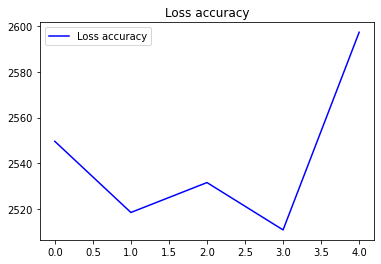

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the loss accuracies for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Loss accuracy')
plt.title('Loss accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

**Yusuf**

In [ ]:
# Download image zip
downloaded = drive.CreateFile({'id':"10K44l5A__7DrNTZStVP6-vebBbWp9f4Y"})
downloaded.GetContentFile('Dataset.zip') 

# Download CSV data
downloaded = drive.CreateFile({'id':"1v73UDBS2_yUMZ0yTAIrN8i5JyiepIAKo"})
downloaded.GetContentFile('PM10_Data.csv') 

In [ ]:
test_local_zip = "/content/Dataset.zip"

zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/Dataset')

zip_ref.close()

In [ ]:
# Define the training and validation base directories
train_dir = '/tmp/Dataset'

# Directory with training Good pictures
train_Good_dir = os.path.join(train_dir, 'Good')
# Directory with training Moderate pictures
train_Moderate_dir = os.path.join(train_dir, 'Moderate')
# Directory with training Dangerous pictures
train_Dangerous_dir = os.path.join(train_dir, 'Dangerous')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_Good_dir))} images of Good.\n")
print(f"There are {len(os.listdir(train_Moderate_dir))} images of Moderate.\n")
print(f"There are {len(os.listdir(train_Dangerous_dir))} images of Dangerous.\n")

There are 390 images of Good.

There are 176 images of Moderate.

There are 35 images of Dangerous.



In [ ]:
def turn_to_jpg(image_path):
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      im = Image.open(os.path.join(image_path, i))
      im = im.convert("RGB")
      im = im.resize((150, 150))
      im.save(image_path + "/" + Path(i).stem + ".jpg")
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      os.remove(os.path.join(image_path, i))

In [ ]:
# Turn all image to jpg
turn_to_jpg(train_Good_dir)
turn_to_jpg(train_Moderate_dir)
turn_to_jpg(train_Dangerous_dir)

Sample Good image:


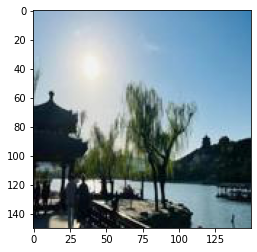

Sample Moderate image:


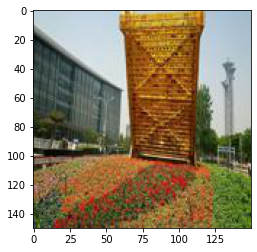

Sample Dangerous image:


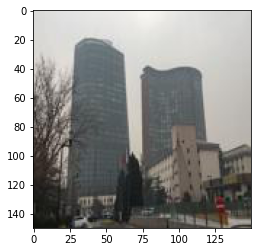

In [ ]:
print("Sample Good image:")
plt.imshow(load_img(f"{os.path.join(train_Good_dir, os.listdir(train_Good_dir)[0])}"))
plt.show()

print("Sample Moderate image:")
plt.imshow(load_img(f"{os.path.join(train_Moderate_dir, os.listdir(train_Moderate_dir)[0])}"))
plt.show()

print("Sample Dangerous image:")
plt.imshow(load_img(f"{os.path.join(train_Dangerous_dir, os.listdir(train_Dangerous_dir)[0])}"))
plt.show()

In [ ]:
# Load the first example of a Good
sample_image  = load_img(f"{os.path.join(train_Good_dir, os.listdir(train_Good_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (150, 150, 3)


In [ ]:
# Read CSV File
csv_path = "/content/PM10_Data.csv"
df = pd.read_csv(csv_path)
df.head(30)

,Image,PM10,Status
0,Good1,27,Good
1,Good2,27,Good
2,Good3,27,Good
3,Good4,27,Good
4,Good5,27,Good
5,Good6,27,Good
6,Good7,27,Good
7,Good8,59,Good
8,Good9,59,Good
9,Good10,59,Good


In [ ]:
def remove_missing_image(dataset, image_path):
    dataset = np.array(dataset)
    result = []
    data_index = 0
    for i in dataset:
      if os.path.join(i[0] + ".jpg") not in os.listdir(os.path.join(image_path, i[2])):
        result.append(data_index)
      data_index += 1
    return result

In [ ]:
# Split data with ratio train 90% and validation 10%
randomize_train = df.sample(frac = 0.9)
randomize_val = df.drop(randomize_train.index)
not_found_image = remove_missing_image(randomize_train, train_dir)
train_image = np.delete(np.array(randomize_train), not_found_image, axis=0)

not_found_image = remove_missing_image(randomize_val, train_dir)
val_image = np.delete(np.array(randomize_val), not_found_image, axis=0)

In [ ]:
def process_image(image_path, image_list):
    ori_image = Image.open(os.path.join(image_path, image_list[2] + "/" + image_list[0] + ".jpg"))
    ori_image = ori_image.resize((150, 150))
    gray_image = ImageOps.grayscale(ori_image)
    return np.array(gray_image).flatten()

In [ ]:
# Open image and put it in array
image_array = []
for i in train_image:
  image_array.append(process_image(train_dir, i))
image_array = np.array(image_array)

val_array = []
for i in val_image:
  val_array.append(process_image(train_dir, i))
val_array = np.array(val_array)

In [ ]:
train_labels = np.delete(train_image, 0, 1)
train_labels = np.delete(train_labels, 1, 1)

val_labels = np.delete(val_image, 0, 1)
val_labels = np.delete(val_labels, 1, 1)

In [ ]:
image_array = np.reshape(image_array, (image_array.shape[0], image_array.shape[1], 1))
image_array.shape

(180, 22500, 1)

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1/255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  
  validation_datagen = ImageDataGenerator(rescale=1/255)

#   validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
#                                                                 batch_size=32, 
#                                                                 class_mode='binary',
#                                                                 target_size=(150, 150))
  
  return train_generator, validation_generator

In [ ]:
# # Test generators
# train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

NameError: ignored

TRANSFER LEARNING

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-05 17:30:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   237MB/s    in 0.4s    

2022-06-05 17:30:22 (237 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make non trainable layer
  for layers in pre_trained_model.layers:
    layers.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)  
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
# model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

NameError: ignored